# Code to rescale CEF parameters from $\rm{Nd_3Sb_3Mg_2O_{14}}$ to $\rm{Pr_3Sb_3Mg_2O_{14}}$

Allen Scheie
December, 2017

## Theory

As proved in the NdMg document,
$$
B_{n}^{m}= \underbrace{-\gamma_{nm}|e|C_{nm}}_{\text{ion independent}}
\underbrace{\left\langle r^{n}\right\rangle \theta_{n}}_{\text{ion dependent}}
$$

So assuming we have precisely the same ligand environment (which is true to first order) we can re-scale the $B$ parameters with $\left\langle r^{n}\right\rangle \theta_{n}$:

$$
\boxed{
\big( B_{n}^{m} \big)_B = \big( B_{n}^{m} \big)_A
 \frac{\left\langle r^{n}\right\rangle_B \theta_{n B}}{\left\langle r^{n}\right\rangle_A \theta_{n A}}
}
$$

In [1]:
# Import libraries
%matplotlib notebook
# Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
import sys
import CEF_calculations as cef
import time
import plotformat as pf


# Put the above values for the Debye Waller factor in a dictionary
AtomDisp = {}
AtomDisp['NdMg'] = {}
AtomDisp['NdMg'][6] = 0.0
AtomDisp['NdMg'][100] = 0.045148437500000055
AtomDisp['NdMg'][200] = 0.084953125000000129

AtomDisp['NdZn'] = {}
AtomDisp['NdZn'][6] = 0.0
AtomDisp['NdZn'][100] = 0.045175781250000054
AtomDisp['NdZn'][200] = 0.087765625000000125

AtomDisp['PrMg'] = {}
AtomDisp['PrMg'][6] = 0.0
AtomDisp['PrMg'][100] = 0.045941406250000053
AtomDisp['PrMg'][200] = 0.076910156250000111



# Import Resolution Function

resf150 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc150.txt', skip_header=1, unpack=True)
resf80 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc80.txt', skip_header=1, unpack=True)
resf40 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc40.txt', skip_header=1, unpack=True)

def resfunc(Ei, deltaE):
    if Ei == 150:
        deltaE = np.interp(deltaE, resf150[0], resf150[1])
    elif Ei == 80:
        deltaE =  np.interp(deltaE, resf80[0], resf80[1])
    elif Ei == 40:
        deltaE =  np.interp(deltaE, resf40[0], resf40[1])
    else: print("Ei not in resfunc data.")
    return deltaE



# Test out NeutronSpectrum2D function
Qarray = np.arange(0.1,15,0.1)
Earray = np.arange(5,150,0.5)

def arrayedges(xarray):
    diff = (xarray[1:] - xarray[:-1]) / 2.  # get edges of arrays
    return np.hstack((xarray[0]-diff[0], xarray[:-1]+diff, xarray[-1]+diff[-1]))
Eedges = arrayedges(Earray)
Qedges = arrayedges(Qarray)

[6, 6, 6, 100, 100, 100, 200, 200, 200]
[40, 80, 150, 40, 80, 150, 40, 80, 150]


<IPython.core.display.Javascript object>


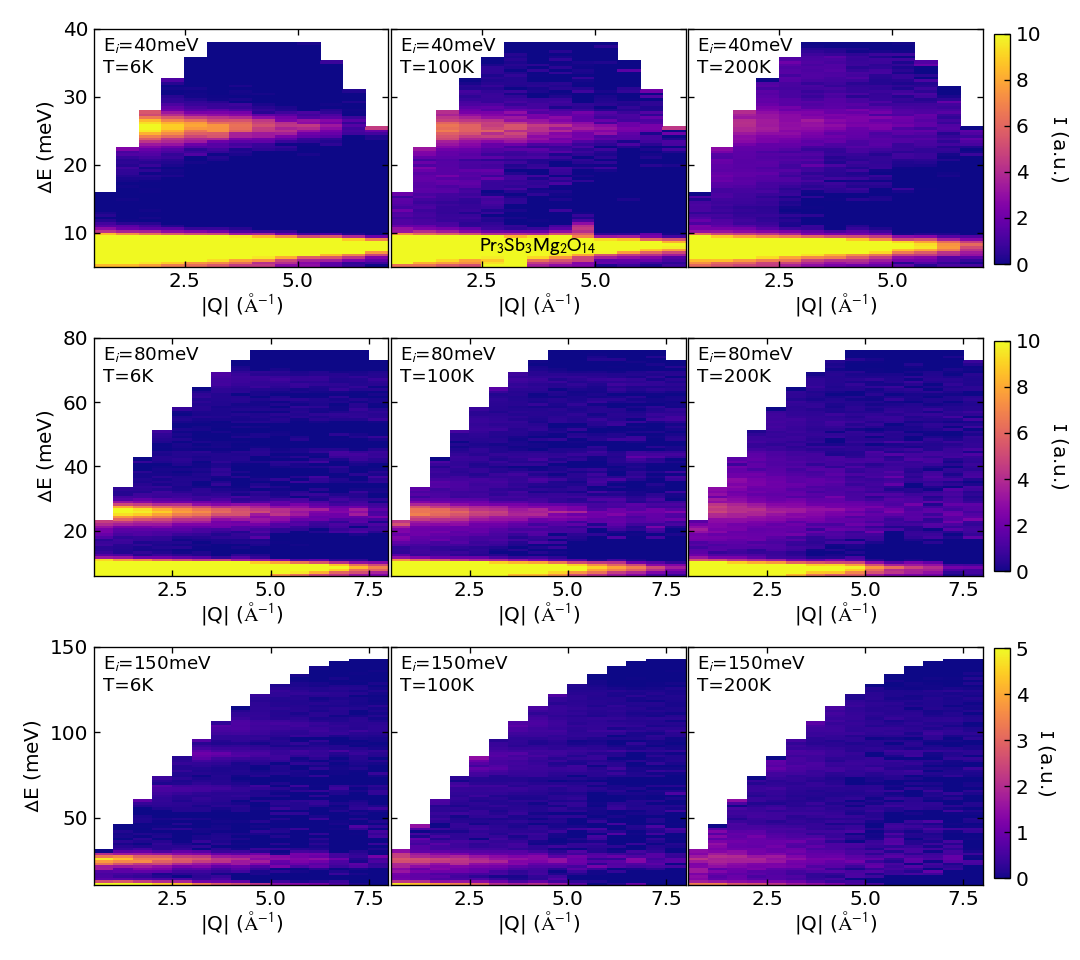

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [2]:
# ### Import Susceptibility data
# # Import data
# datafile = '/home/allen/Documents/Neutrons/Nd3Sb3Mg2O14/Susceptibility/'+\
#                 'Nd3Sb3Mg2O14 MT 1.8 to 300 5000 oe 53.8 mg.dc.dat'
# #ImportData
# DataA = np.genfromtxt(datafile, delimiter=',', skip_header=31)
# Temp = DataA[:,3]
# Mag = DataA[:,4]

# #Normalize the data
# mass = 0.0538 #mass in g of sample
# Molarmass = 3*144.242 + 3*121.76 + 2*24.305 + 14*15.9994  #molar mass of sample (g/mol)
# field = 5000

# NormMag = Mag / mass * Molarmass / 3 / field
# Chiminus1 = 1/NormMag  # in emu/Oe/mol
# Chiminus1 *= 1/(1.078283e20*10000/6.0221409e23)  # in mu_B/T/ion


# Import data
slicesdirectory = './Data/Slices/'

# Define file names by my naming convention
filenames = []
for T in [6, 100, 200]:
    for E in [40,80,150]:
        filenames.append('PrMg_T'+str(T)+'_E'+str(E)+'_slice.iexy')

data = [cef.importGridfile(slicesdirectory+f) for i,f in enumerate(filenames)]
# # Intensity Error |Q| DeltaE

datatemps = [int(name.split('_')[1][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION
dataengys = [int(name.split('_')[2][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION

print(datatemps)
print(dataengys)

#print data[1][0]



ntemps = len(set(datatemps))
nengys = len(set(dataengys))


plt.rc('font',**{'size':12})
    
f, ax = plt.subplots(3,3, figsize=(9,8))


cax1 = f.add_axes([0.92,0.725,0.015,0.24])
cax2 = f.add_axes([0.92,0.405,0.015,0.24])
cax3 = f.add_axes([0.92,0.085,0.015,0.24])
cax = [cax1, cax2, cax3]

minImaxI = [(0,0.001),(0,0.001),(0,0.0005)]
cmap = 'plasma'
for i in range(nengys):
    minI, maxI = minImaxI[i]
    for j in range(ntemps):
        k = j*ntemps + i
        try: 
            intensity = np.ma.masked_where(np.isnan(data[k]['I']), data[k]['I'])
            ax[i,j].pcolormesh(arrayedges(data[k]['Q']), arrayedges(data[k]['E']), intensity, 
                               rasterized = True, cmap = cmap, vmin = minI, vmax = maxI)
            # Set axis labels
            if j == 0: ax[i,j].set_ylabel('$\Delta$E (meV)')
            else: ax[i,j].yaxis.set_ticklabels([])
            ax[i,j].set_xlabel('|Q| ($\\rm \AA^{-1}$)', labelpad=0)
            # set text in frame
            ax[i,j].text(0.03, 0.97, 'E$_i$='+str(dataengys[k])+'meV'+'\nT='+str(datatemps[k])+'K', fontsize=11,
                        horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
        except IndexError:
            break
            
    norm = Normalize(vmin=minI*1e4, vmax=maxI*1e4)
    mappable = cm.ScalarMappable(norm = norm, cmap=cmap)
    mappable.set_array([])
    cb = f.colorbar(mappable, cax[i], cmap =cmap, norm=norm ,orientation='vertical',
                       ticklocation = 'right',drawedges = False)
    cb.solids.set_edgecolor("face")
    #cb.set_ticks(MultipleLocator(0.02))
    cb.formatter.set_powerlimits((-1, 2))
    cb.ax.xaxis.set_label_coords(1.24,0.6)
    #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%f'))
    cb.set_label('$\\rm I$ (a.u.)', rotation = -90, labelpad = 17)

ax[0,1].text(0.5,0.04,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$', color='k',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[0,1].transAxes)
    
plt.tight_layout()
f.subplots_adjust(wspace=0.01, hspace=0.3, right=0.91)
plt.show()

In [3]:
import pickle

with open('NdMg_CEF_fitResults.pickle', 'rb') as f:
    NdFit1, NdFitB, NdFitGamma, NdFitPrefactors = pickle.load(f)
    #NdCoefFit1, FitCoefficients, FitGamma, FitPrefactors = pickle.load(f)
    
with open('PrMg_CEF_fitResults.pickle', 'rb') as f:
    PrFit1, PrFitB, PrFitGamma, PrFitPrefactors = pickle.load(f)
    #NdCoefFit1, FitCoefficients, FitGamma, FitPrefactors = pickle.load(f)

PrFit1.diagonalize()
PrFit1.printEigenvectors()


 Eigenvalues 	 Eigenvectors
		----------------------------------------------------------------------
0.00000 	|  [ 0.33   0.018  0.211 -0.066 -0.827  0.066  0.211 -0.018  0.33 ]  |
7.85748 	|  [ 0.138 -0.076  0.002 -0.672  0.216  0.672  0.002  0.076  0.138]  |
25.98164 	|  [ 0.573 -0.051  0.294 -0.287  0.    -0.287 -0.294 -0.051 -0.573]  |
62.73392 	|  [ 0.593 -0.158 -0.129  0.198  0.369 -0.198 -0.129  0.158  0.593]  |
86.58469 	|  [-0.331  0.221  0.127 -0.57   0.    -0.57  -0.127  0.221  0.331]  |
106.95199 	|  [ 0.224  0.141 -0.62  -0.214 -0.    -0.214  0.62   0.141 -0.224]  |
122.73356 	|  [-0.069 -0.399  0.558  0.065  0.202 -0.065  0.558  0.399 -0.069]  |
181.17306 	|  [ 0.127  0.557  0.357  0.013  0.305 -0.013  0.357 -0.557  0.127]  |
197.14870 	|  [-0.108 -0.655 -0.113 -0.216 -0.    -0.216  0.113 -0.655  0.108]  |
		----------------------------------------------------------------------



### Rescale the CEF parameters (B)

In [4]:
ion1 = 'Nd3+'
ion2 = 'Pr3+'

ScaledB = []
Pr_O = []

ionJ = cef.Jion[ion2][2]

i=0
for n in range(2,8,2):
    for m in range(0,n+1):
        Pr_O.append(  cef.StevensOp(ionJ,n,m)  )
        ScaledB.append(cef.rescaleCEF(ion1=ion1, ion2=ion2,B=NdFitB[i],n=n))
        #print(n,m,'\t', NdFitB[i],'\t', ScaledB[i])
        i+=1
        
PrScaled1 = cef.CFLevels(Pr_O, ScaledB)
PrScaled1.diagonalize()
PrScaled1.printEigenvectors()
PrScaled1.printLaTexEigenvectors()


 Eigenvalues 	 Eigenvectors
		----------------------------------------------------------------------
0.00000 	|  [ 0.081  0.032 -0.145 -0.081  0.964  0.081 -0.145 -0.032  0.081]  |
32.86008 	|  [ 0.011 -0.045 -0.08   0.698  0.094 -0.698 -0.08   0.045  0.011]  |
105.32019 	|  [-0.07   0.04   0.078 -0.698  0.    -0.698 -0.078  0.04   0.07 ]  |
124.74301 	|  [ 0.648 -0.229  0.155 -0.061  0.    -0.061 -0.155 -0.229 -0.648]  |
126.02266 	|  [-0.643  0.283 -0.056  0.017  0.076 -0.017 -0.056 -0.283 -0.643]  |
163.84852 	|  [-0.251 -0.355  0.553  0.067 -0.     0.067 -0.553 -0.355  0.251]  |
164.07626 	|  [ 0.26   0.546 -0.343  0.004 -0.183 -0.004 -0.343 -0.546  0.26 ]  |
189.55528 	|  [-0.109 -0.565 -0.405 -0.067 -0.    -0.067  0.405 -0.565  0.109]  |
189.80977 	|  [ 0.111  0.344  0.593  0.078  0.149 -0.078  0.593 -0.344  0.111]  |
		----------------------------------------------------------------------

\begin{table*}
\caption{Eigenvectors and Eigenvalues...}
\begin{ruledtabular}
\begin{tabu

3.25
5.25


<IPython.core.display.Javascript object>


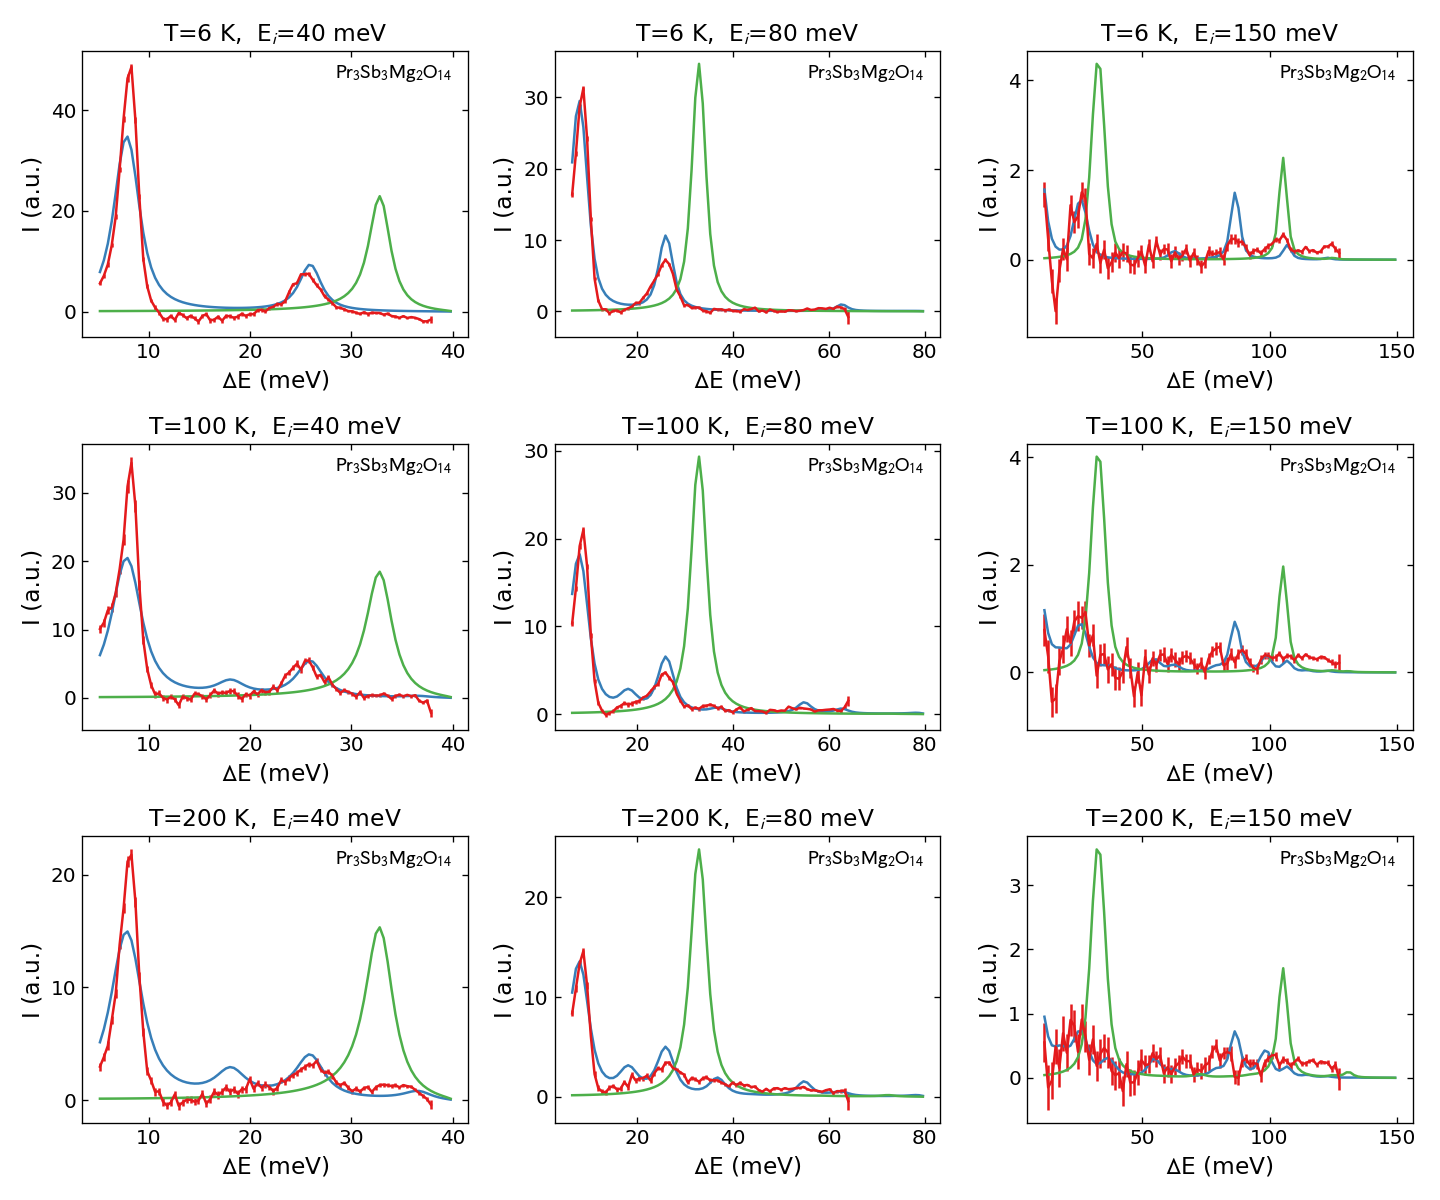

In [5]:
print(data[1]['Q'][5])
print(data[2]['Q'][9])
Qlim = {40:5, 80:5, 150:9}  #indices of the Q cuts that we want to plot


gammas = np.repeat(PrFitGamma, len(set(datatemps)))
prefc = np.tile(PrFitPrefactors, len(dataengys))
Pr_intens = []
Pr_scaled_intens = []
Nd_fitx = []
for i, t in enumerate(datatemps):
    Pr_intens.append(prefc[i]*PrFit1.neutronSpectrum2D(Earray=data[i]['E'], Qarray = data[i]['Q'], Temp=t, 
                                                Ei=dataengys[i], ResFunc=lambda de: resfunc(dataengys[i],de), 
                                                gamma=gammas[i],DebyeWaller = AtomDisp['PrMg'][t], Ion = 'Pr3+') )
    Pr_scaled_intens.append(prefc[i]*PrScaled1.neutronSpectrum2D(Earray=data[i]['E'], Qarray = data[i]['Q'], Temp=t, 
                                                Ei=dataengys[i], ResFunc=lambda de: resfunc(dataengys[i],de), 
                                                gamma=gammas[i],DebyeWaller = AtomDisp['PrMg'][t], Ion = 'Pr3+') )

f, ax = plt.subplots(3,3, figsize=(12,10))

multfac = 10000
for i in range(ntemps):
    for j in range(nengys):
        k = i*ntemps + j
        try: 
            ax[i,j].errorbar(data[k]['E'], multfac*data[k]['I'][:,Qlim[dataengys[k]]], 
                             multfac*data[k]['dI'][:,Qlim[dataengys[k]]])
            ax[i,j].plot(data[k]['E'], multfac*Pr_intens[k][:,Qlim[dataengys[k]]], lw=1.5)
            ax[i,j].plot(data[k]['E'], multfac*Pr_scaled_intens[k][:,Qlim[dataengys[k]]], lw=1.5)
            ax[i,j].set_ylabel('I (a.u.)',fontsize=14)
            ax[i,j].set_xlabel('$\Delta$E (meV)',fontsize=14)
            #ax[i,j].set_ylim(0,0.0006)
            #ax[i,j].legend(frameon=False, fontsize=14)
            ax[i,j].text(0.96,0.96,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
                horizontalalignment='right',verticalalignment='top', transform=ax[i,j].transAxes)
            ax[i,j].set_title('T='+str(datatemps[k])+' K,  '+'E$_i$='+str(dataengys[k])+' meV', fontsize=14)
        except IndexError:
            break

plt.tight_layout()
plt.show()



<IPython.core.display.Javascript object>


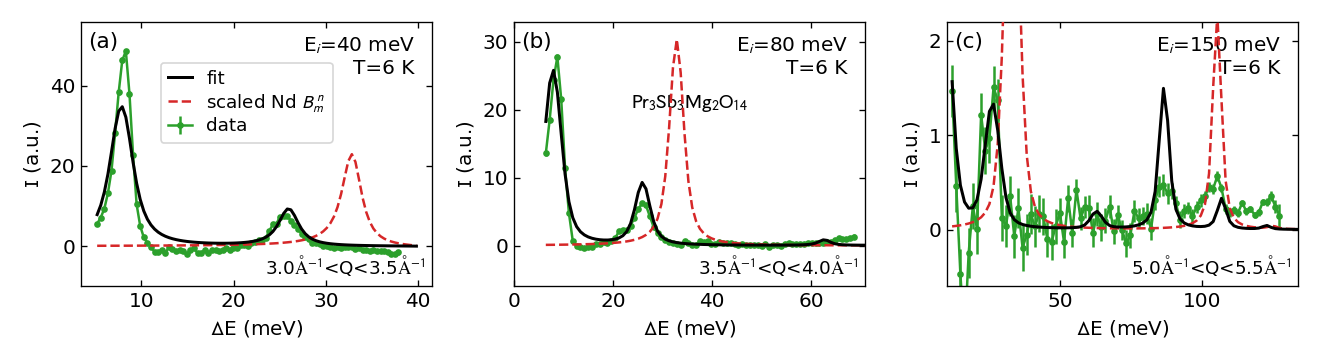

In [6]:
#cpal = plt.cm.Set1(np.arange(9))
cpal = plt.cm.tab10(np.arange(10))
#cpal = plt.cm.Dark2(np.arange(8))

Qlim = {40:5, 80:6, 150:9}

plt.rc('font',**{'size':12})

f, ax = plt.subplots(1,3, figsize=(11,3))

axeslabels = 'abcdefghijk'
multfac = 10000
for i in range(ntemps):
    k = i
    try: 
        ax[i].errorbar(data[k]['E'], multfac*data[k]['I'][:,Qlim[dataengys[k]]], 
                         multfac*data[k]['dI'][:,Qlim[dataengys[k]]], 
                       marker='.', color=cpal[2], label='data')
        ax[i].plot(data[k]['E'], multfac*Pr_intens[k][:,Qlim[dataengys[k]]], lw=1.8,
                    color='k', label='fit', zorder=5)
        ax[i].plot(data[k]['E'], multfac*Pr_scaled_intens[k][:,Qlim[dataengys[k]]], lw=1.5, ls='--',
                    color=cpal[3], label='scaled Nd $B_m^n$', zorder=4)
        ax[i].set_ylabel('$\\rm I$ (a.u.)')
        #ax[i,j].set_xlabel('$\Delta$E (meV)')
        #ax[i,j].set_ylim(0,0.0006)
        #ax[i,j].legend(frameon=False, fontsize=14)
        ax[i].text(0.95,0.95,'E$_i$='+str(dataengys[k])+' meV\n'+'T='+str(datatemps[k])+' K',
            horizontalalignment='right',verticalalignment='top', transform=ax[i].transAxes)
        ax[i].text(0.98,0.03, 
                     str(np.mean(data[0]['Q'][Qlim[dataengys[k]]-1:Qlim[dataengys[k]]+1]))+'$\\rm \AA^{-1}$'+
                       '<Q<'+
                     str(np.mean(data[0]['Q'][Qlim[dataengys[k]]:Qlim[dataengys[k]]+2]))+
                     '$\\rm \AA^{-1}$', fontsize=11,
            horizontalalignment='right',verticalalignment='bottom', transform=ax[i].transAxes)
        ax[i].set_xlabel('$\Delta$E (meV)')
        #ax[i,j].set_title('T='+str(datatemps[k])+' K,  '+'E$_i$='+str(dataengys[k])+' meV', fontsize=15)

        if i == 0:
            ax[i].set_ylim(-10,56)
        if i == 1: 
            ax[i].set_xlim(0,71)
            ax[i].set_ylim(-6,33)
        elif i == 2:
            ax[i].set_xlim(10,134)
            ax[i].set_ylim(-0.6,2.2)
            ax[i].set_yticks([0,1,2])

        # Label panels
        ax[i].text(0.02, 0.96, '('+axeslabels[i]+')', fontsize=13, zorder=10,
                horizontalalignment='left',verticalalignment='top', transform=ax[i].transAxes)

    except IndexError:
        break

ax[0].legend(loc=2, bbox_to_anchor=(0.2,0.88), handlelength=1.3, fontsize=11, labelspacing=0.2)            
ax[1].text(0.5,0.65,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[1].transAxes)

plt.tight_layout()
f.subplots_adjust(hspace=0.01)

In [7]:

# calcsuscep = NdCoefFit1.susceptibility('Nd3+', Temp,  0.5, 0.001)

# f, ax = plt.subplots()
# plt.plot(Temp,Chiminus1, '.', label='data')
# plt.plot(Temp,-1/calcsuscep, label='theory')
# plt.xlabel('$T$ (K)')
# plt.ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)')
# plt.legend()
# ax.text(0.5,0.03,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$',
#         horizontalalignment='center',verticalalignment='bottom', transform=ax.transAxes)

## Test: is the ground state easy axis or easy plane?

In [8]:
# Compute Magnetization
ion = 'Pr3+'

temp = 2
fieldstrengths = np.arange(-9,9,0.2)
magnetization = np.zeros((len(fieldstrengths), 3, 3))
netmag = np.zeros(len(fieldstrengths))

theta, phi = 1, 1*np.pi/6
Bvect = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
Bvect = np.array([1,1,1])/np.sqrt(3)

for i, fs in enumerate(fieldstrengths):
    magnetization[i,0] = PrScaled1.magnetization(ion, temp, [fs,0,0])
    magnetization[i,1] = PrScaled1.magnetization(ion, temp, [0,fs,0])
    magnetization[i,2] = PrScaled1.magnetization(ion, temp, [0,0,fs])
    netmag[i] = -np.dot(Bvect, np.array(PrScaled1.magnetization(ion, temp, fs*Bvect)))

<IPython.core.display.Javascript object>


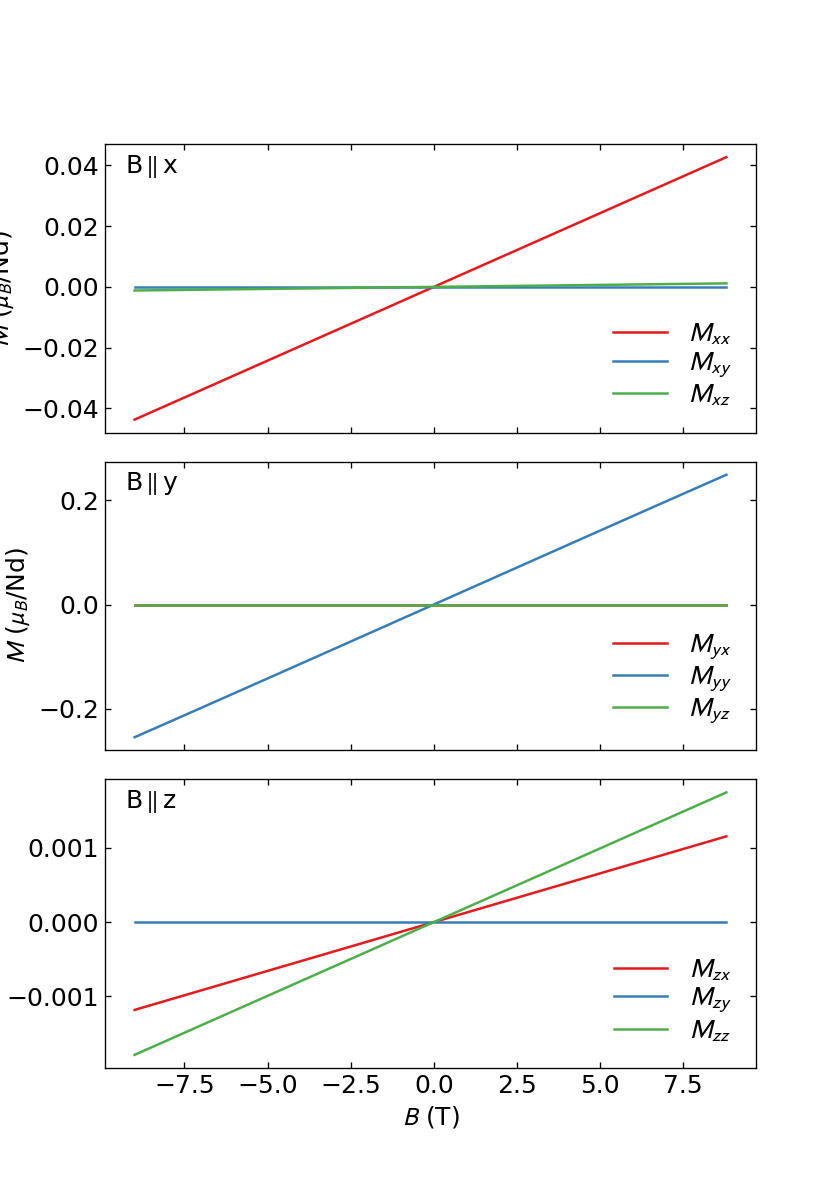

Text(0.5,0,'$B$ (T)')

In [9]:
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'font.size': 15}
plt.rcParams.update(params)

f, ax = plt.subplots(3,1, figsize=(7,10), sharex=True)
direction = ['x','y','z']
for i in range(3):
    ax[i].plot(fieldstrengths,-magnetization[:,i,0], label='$M_{'+direction[i]+'x}$')
    ax[i].plot(fieldstrengths,-magnetization[:,i,1], label='$M_{'+direction[i]+'y}$')
    ax[i].plot(fieldstrengths,-magnetization[:,i,2], label='$M_{'+direction[i]+'z}$')
    ax[i].text(0.03,0.97,'B$\\parallel$'+direction[i],
                horizontalalignment='left',verticalalignment='top', transform=ax[i].transAxes)
    ax[i].legend(loc=4, frameon=False,labelspacing = 0.1, fontsize=16)
    ax[i].set_ylabel('$M$ ($\mu_B$/Nd)')

f.subplots_adjust(hspace=0.1)
ax[2].set_xlabel('$B$ (T)')

# Conclusion:
We cannot rescale these CEF parameters to account for other ions. The symmetry environment is too low.